# NFL Challange

## Import Modules and Data

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
from geopy.geocoders import Nominatim
pd.options.mode.chained_assignment = None  
%matplotlib inline
import mpl_toolkits
import matplotlib.pylab as plt
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.base import BaseEstimator, TransformerMixin

In [18]:
premergerdate=pd.to_datetime('19750601', format='%Y%m%d', errors='ignore')

In [19]:
nfl_stadiums=pd.read_csv("./nfl-scores-and-betting-data/nfl_stadiums.csv",encoding = "utf-8")
nfl_teams=pd.read_csv("./nfl-scores-and-betting-data/nfl_teams.csv",encoding = "utf-8")
nfl_scores=pd.read_csv("./nfl-scores-and-betting-data/spreadspoke_scores.csv",encoding = "utf-8")

In [20]:
#nfl_scores.head(150)
#nfl_stadiums.head()
#nfl_teams.head()

## Functions

In [21]:
def count_null(df,column):
    try:
        for x in column:
            null=sum(pd.isnull(df[x]))
            print(x,null)
    except Exception:
            pass
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out
def ttest(control, treatment):
    #paired t-test; two-tailed p-value      A   ,    B
    (t_score, p_value) = stats.ttest_rel(control, treatment)

    if p_value > 0.05/2:  #Two sided 
        print('There is no significant difference between the two machine learning pipelines (Accept H0)')
    else:
        print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
        if t_score > 0.0: #in the case of regression lower RMSE is better; A is lower 
            print('Machine learning pipeline A is better than B')
        else:
            print('Machine learning pipeline B is better than A')
    return p_value

## Fix Nulls

In [22]:
column_teams=list(nfl_teams.columns)
column_scores=list(nfl_scores.columns)
column_stadiums=list(nfl_stadiums.columns)

In [23]:
nfl_scores.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_detail,weather_temperature,weather_wind_mph,weather_humidity,score_home,score_away,stadium_neutral,schedule_playoff
0,9/2/1966,1966,1,Miami Dolphins,Oakland Raiders,Orange Bowl,NaN,NaN,NaN,NaN,83.0,6.0,71,14.0,23.0,False,False
1,9/3/1966,1966,1,Houston Oilers,Denver Broncos,Rice Stadium,NaN,NaN,NaN,NaN,81.0,7.0,70,45.0,7.0,False,False
2,9/4/1966,1966,1,San Diego Chargers,Buffalo Bills,Balboa Stadium,NaN,NaN,NaN,NaN,70.0,7.0,82,27.0,7.0,False,False
3,9/9/1966,1966,2,Miami Dolphins,New York Jets,Orange Bowl,NaN,NaN,NaN,NaN,82.0,11.0,78,14.0,19.0,False,False
4,9/10/1966,1966,1,Green Bay Packers,Baltimore Colts,Lambeau Field,NaN,NaN,NaN,64 degrees- humidity 62%- wind 8 mph,64.0,8.0,62,24.0,3.0,False,False


### Nulls for NFL Scores

In [24]:
count_null(nfl_scores,column_scores)

schedule_date 0
schedule_season 0
schedule_week 0
team_home 0
team_away 0
stadium 0
team_favorite_id 2601
spread_favorite 2601
over_under_line 2611
weather_detail 7930
weather_temperature 724
weather_wind_mph 724
weather_humidity 4013
score_home 135
score_away 135
stadium_neutral 0
schedule_playoff 0


In [25]:
nfl_scores["schedule_date"]=pd.to_datetime(nfl_scores["schedule_date"])
nfl_scores.dropna(subset=["score_home","over_under_line","weather_temperature","weather_wind_mph"], inplace=True)
nfl_scores=nfl_scores[nfl_scores['schedule_date'].dt.year >= 1980]

In [26]:
nfl_scores.drop(["weather_humidity","weather_detail"], axis=1,inplace=True)

In [27]:
nfl_scores.loc[(nfl_scores.schedule_week == '18'), 'schedule_week'] = '17'
nfl_scores.loc[(nfl_scores.schedule_week == 'Wildcard') | (nfl_scores.schedule_week == 'WildCard'), 'schedule_week'] = '18'
nfl_scores.loc[(nfl_scores.schedule_week == 'Division'), 'schedule_week'] = '19'
nfl_scores.loc[(nfl_scores.schedule_week == 'Conference'), 'schedule_week'] = '20'
nfl_scores.loc[(nfl_scores.schedule_week == 'Superbowl') | (nfl_scores.schedule_week == 'SuperBowl'), 'schedule_week'] = '21'
nfl_scores['schedule_week'] = nfl_scores.schedule_week.astype(int)

In [28]:
count_null(nfl_scores,column_scores)

schedule_date 0
schedule_season 0
schedule_week 0
team_home 0
team_away 0
stadium 0
team_favorite_id 0
spread_favorite 0
over_under_line 0


### Nulls for NFL Teams

In [29]:
count_null(nfl_teams,column_teams)

team_name 0
team_name_short 0
team_id 0
team_id_pfr 0
team_conference 0
team_division 8
team_conference_pre2002 0
team_division_pre2002 2


In [30]:
nfl_teams.head()

,team_name,team_name_short,team_id,team_id_pfr,team_conference,team_division,team_conference_pre2002,team_division_pre2002
0,Arizona Cardinals,Cardinals,ARI,CRD,NFC,NFC West,NFC,NFC West
1,Phoenix Cardinals,Cardinals,ARI,CRD,NFC,NaN,NFC,NFC East
2,St. Louis Cardinals,Cardinals,ARI,ARI,NFC,NaN,NFC,NFC East
3,Atlanta Falcons,Falcons,ATL,ATL,NFC,NFC South,NFC,NFC West
4,Baltimore Ravens,Ravens,BAL,RAV,AFC,AFC North,AFC,AFC Central


In [31]:
null_columns=nfl_teams.columns[nfl_teams.isnull().any()]
print(nfl_teams[nfl_teams["team_division_pre2002"].isnull()][null_columns])

   team_division team_division_pre2002
14     AFC South                   NaN
26           NaN                   NaN


### Nulls for NFL Stadiums

In [32]:
nfl_stadiums['stadium_close'] = nfl_stadiums['stadium_close'].fillna(2020)
nfl_stadiums['LATITUDE'] = nfl_stadiums['LATITUDE'].fillna(0)
nfl_stadiums['LONGITUDE'] = nfl_stadiums['LATITUDE'].fillna(0)
nfl_stadiums['ELEVATION'] = nfl_stadiums['LATITUDE'].fillna(0)
nfl_stadiums=nfl_stadiums[(nfl_stadiums['stadium_close'] >= 1980)]
count_null(nfl_stadiums,column_stadiums)

stadium_name 0
stadium_location 0
stadium_open 23
stadium_close 0
stadium_type 7
stadium_address 9
stadium_weather_station_code 10
stadium_weather_type 7
stadium_capacity 58
stadium_surface 45
STATION 44
NAME 44
LATITUDE 0
LONGITUDE 0
ELEVATION 0


In [33]:
print(len(nfl_stadiums))

nfl_stadiums.head(100)

96


,stadium_name,stadium_location,stadium_open,stadium_close,stadium_type,stadium_address,stadium_weather_station_code,stadium_weather_type,stadium_capacity,stadium_surface,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION
0,Alamo Dome,"San Antonio, TX",NaN,2020.0,indoor,"100 Montana St, San Antonio, TX 78203",78203,dome,72000,FieldTurf,NaN,NaN,0.00000,0.00000,0.00000
1,Alltel Stadium,"Jacksonville, FL",NaN,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000
2,Alumni Stadium,"Chestnut Hill, MA",NaN,2020.0,outdoor,"Perimeter Rd, Chestnut Hill, MA 02467",2467,cold,NaN,Grass,NaN,NaN,0.00000,0.00000,0.00000
3,Anaheim Stadium,"Anaheim, CA",1980.0,1994.0,outdoor,"2000 E Gene Autry Way, Anaheim, CA 92806",92806,warm,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000
4,Arrowhead Stadium,"Kansas City, MO",1972.0,2020.0,outdoor,"1 Arrowhead Dr, Kansas City, MO 64129",64129,cold,"76,416",Grass,US1MOJC0028,"KANSAS CITY 5.1 SE, MO US",39.06920,39.06920,39.06920
5,AT&T Stadium,"Arlington, TX",2009.0,2020.0,retractable,"1 AT&T Way, Arlington, TX 76011",76011,dome,"80,000",FieldTurf,USC00410337,"ARLINGTON SIX FLAGS, TX US",32.75720,32.75720,32.75720
6,Atlanta-Fulton County Stadium,"Atlanta, GA",1966.0,1991.0,outdoor,"521 Capitol Avenue SE, Atlanta, Georgia 30312",30312,warm,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000
7,Balboa Stadium,"San Diego, CA",NaN,2020.0,outdoor,"Balboa Stadium, San Diego, CA 92101",92101,warm,NaN,Grass,NaN,NaN,0.00000,0.00000,0.00000
8,Bank of America Stadium,"Charlotte, NC",1996.0,2016.0,outdoor,"800 S Mint St, Charlotte, NC 28202",28202,moderate,"73,778",Grass,USW00013881,"CHARLOTTE DOUGLAS AIRPORT, NC US",35.22360,35.22360,35.22360
9,Busch Memorial Stadium,"St. Louis, MO",1966.0,1995.0,outdoor,"700 Clark Ave, St. Louis, MO 63102",63102,cold,NaN,NaN,USC00238791,"WEBSTER GROVES, MO US",38.56667,38.56667,38.56667


In [34]:
geolocator = Nominatim(user_agent="NFL")
for i, row in nfl_stadiums.iterrows():
    try:
        if nfl_stadiums.LATITUDE[i]==0:
            location = geolocator.geocode(nfl_stadiums.stadium_address[i])
            nfl_stadiums.LATITUDE[i]=location.latitude
            nfl_stadiums.LONGITUDE[i]=location.longitude
            nfl_stadiums.ELEVATION[i]=location.altitude
        else:
            pass
    except:
        pass
        

In [35]:
nfl_stadiums.dropna(subset=["stadium_open"], inplace=True)
nfl_stadiums.drop(["NAME","stadium_surface", "stadium_capacity", "STATION","stadium_weather_station_code"], axis=1,inplace=True)

In [36]:
count_null(nfl_stadiums,column_stadiums)

stadium_name 0
stadium_location 0
stadium_open 0
stadium_close 0
stadium_type 0
stadium_address 0


In [37]:
nfl_stadiums

,stadium_name,stadium_location,stadium_open,stadium_close,stadium_type,stadium_address,stadium_weather_type,LATITUDE,LONGITUDE,ELEVATION
3,Anaheim Stadium,"Anaheim, CA",1980.0,1994.0,outdoor,"2000 E Gene Autry Way, Anaheim, CA 92806",warm,33.799625,-117.889094,0.00000
4,Arrowhead Stadium,"Kansas City, MO",1972.0,2020.0,outdoor,"1 Arrowhead Dr, Kansas City, MO 64129",cold,39.069200,39.069200,39.06920
5,AT&T Stadium,"Arlington, TX",2009.0,2020.0,retractable,"1 AT&T Way, Arlington, TX 76011",dome,32.757200,32.757200,32.75720
6,Atlanta-Fulton County Stadium,"Atlanta, GA",1966.0,1991.0,outdoor,"521 Capitol Avenue SE, Atlanta, Georgia 30312",warm,33.741551,-84.387892,0.00000
8,Bank of America Stadium,"Charlotte, NC",1996.0,2016.0,outdoor,"800 S Mint St, Charlotte, NC 28202",moderate,35.223600,35.223600,35.22360
9,Busch Memorial Stadium,"St. Louis, MO",1966.0,1995.0,outdoor,"700 Clark Ave, St. Louis, MO 63102",cold,38.566670,38.566670,38.56667
10,Candlestick Park,"San Francisco, CA",1960.0,2013.0,outdoor,"490 Jamestown Ave, San Francisco, CA 94124",moderate,37.619700,37.619700,37.61970
11,CenturyLink Field,"Seattle, WA",2002.0,2020.0,outdoor,"800 Occidental Ave S, Seattle, WA 98134",moderate,47.652300,47.652300,47.65230
12,Cinergy Field,"Cincinnati, OH",1970.0,1999.0,outdoor,"201 East Joe Nuxhall Way, Cincinnati 45202",cold,39.100000,39.100000,39.10000
13,Cleveland Municipal Stadium,"Cleveland, OH",1931.0,1995.0,outdoor,"1085 West 3rd Street, Cleveland, Ohio 44114",cold,41.405700,41.405700,41.40570


## EDA

### EDA for NFL_Scores

In [38]:
nfl_scores.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,score_home,score_away,stadium_neutral,schedule_playoff
2734,1980-09-07,1980,1,Buffalo Bills,Miami Dolphins,Ralph Wilson Stadium,MIA,-3.0,35,64.0,8.0,17.0,7.0,False,False
2735,1980-09-07,1980,1,Cincinnati Bengals,Tampa Bay Buccaneers,Cinergy Field,TB,-1.0,34,72.0,9.0,12.0,17.0,False,False
2736,1980-09-07,1980,1,Green Bay Packers,Chicago Bears,Lambeau Field,CHI,-6.0,35,65.0,5.0,12.0,6.0,False,False
2737,1980-09-07,1980,1,Kansas City Chiefs,Oakland Raiders,Arrowhead Stadium,KC,-3.0,42,82.0,10.0,14.0,27.0,False,False
2738,1980-09-07,1980,1,Los Angeles Rams,Detroit Lions,Anaheim Stadium,LAR,-9.0,38,66.0,11.0,20.0,41.0,False,False


In [39]:
nfl_scores.shape

(9181, 15)

In [40]:
nfl_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9181 entries, 2734 to 12264
Data columns (total 15 columns):
schedule_date          9181 non-null datetime64[ns]
schedule_season        9181 non-null int64
schedule_week          9181 non-null int64
team_home              9181 non-null object
team_away              9181 non-null object
stadium                9181 non-null object
team_favorite_id       9181 non-null object
spread_favorite        9181 non-null float64
over_under_line        9181 non-null object
weather_temperature    9181 non-null float64
weather_wind_mph       9181 non-null float64
score_home             9181 non-null float64
score_away             9181 non-null float64
stadium_neutral        9181 non-null bool
schedule_playoff       9181 non-null bool
dtypes: bool(2), datetime64[ns](1), float64(5), int64(2), object(5)
memory usage: 1022.1+ KB


In [42]:
nfl_scores.describe()

,schedule_season,schedule_week,spread_favorite,weather_temperature,weather_wind_mph,score_home,score_away
count,9181.000000,9181.000000,9181.000000,9181.000000,9181.000000,9181.000000,9181.000000
mean,1999.701884,8.921033,-5.348219,59.752423,7.389936,22.561159,19.880841
std,10.993210,4.969030,3.415997,15.481616,5.692980,10.349465,10.042576
min,1980.000000,1.000000,-26.500000,-6.000000,0.000000,0.000000,0.000000
25%,1990.000000,5.000000,-7.000000,49.000000,2.000000,16.000000,13.000000
50%,2000.000000,9.000000,-4.500000,63.000000,8.000000,22.000000,20.000000
75%,2009.000000,13.000000,-3.000000,72.000000,11.000000,30.000000,27.000000
max,2018.000000,21.000000,0.000000,97.000000,40.000000,62.000000,59.000000


In [44]:
nfl_scores.columns

Index(['schedule_date', 'schedule_season', 'schedule_week', 'team_home',
       'team_away', 'stadium', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'weather_temperature', 'weather_wind_mph',
       'score_home', 'score_away', 'stadium_neutral', 'schedule_playoff'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a17d7cb70>,
      dtype=object)

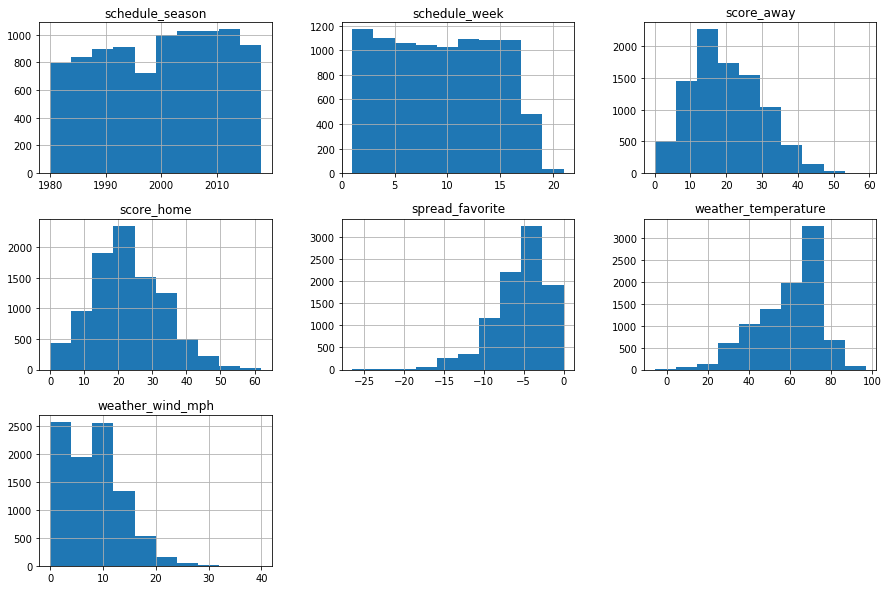

In [49]:
num_nfl_scores = nfl_scores[["schedule_season","schedule_week","spread_favorite",
                            "weather_temperature","weather_wind_mph","score_home","score_away"]]
num_nfl_scores.hist(figsize=(15,10))

In [60]:
correlations = nfl_scores.corr()
correlations['spread_favorite'].sort_values(ascending=False)

spread_favorite        1.000000
score_away             0.125770
weather_temperature    0.066207
stadium_neutral        0.010537
schedule_playoff      -0.007796
schedule_season       -0.015780
weather_wind_mph      -0.028922
schedule_week         -0.076689
score_home            -0.140107
Name: spread_favorite, dtype: float64

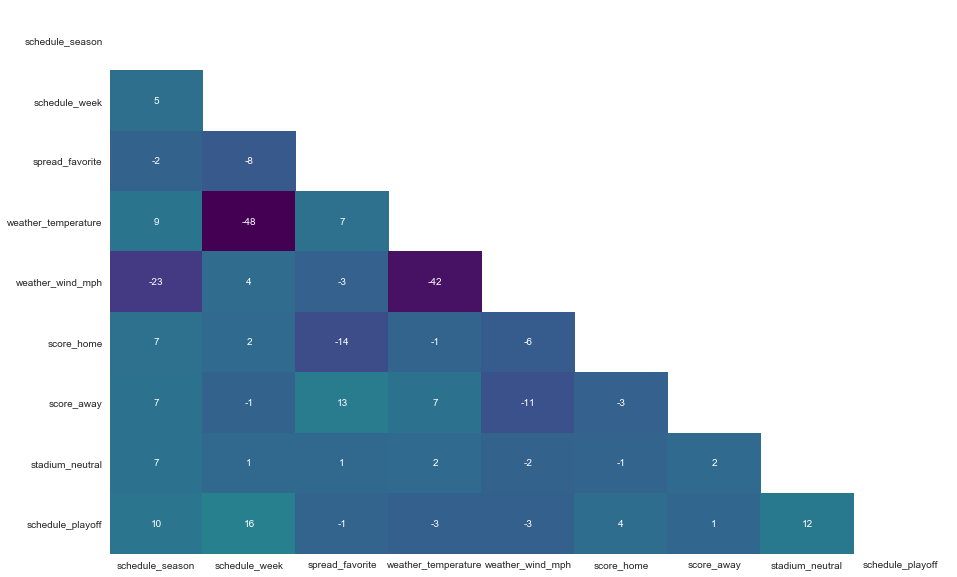

In [61]:
sns.set_style("white")
mask = np.zeros_like(correlations , dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15,10))
sns.heatmap(correlations*100, 
            annot=True,fmt='.0f', 
            mask=mask, cbar=False,cmap='viridis')

### EDA for NFL Teams

In [ ]:
nfl_teams.head()

#### Find the total number of teams
There are 33 unique teams. 

In [ ]:
unique_teams = nfl_teams['team_name_short'].unique()
print('# of Unique Teams (all eras)',len(unique_teams))
unique_teams

#### Find the teams who have moved cities
Seven teams have moved (listed below) with the Cardinals moving the most (3 times)

In [ ]:
team_counts = nfl_teams['team_name_short'].value_counts()
moved_teams = team_counts[team_counts>1]

print('# of Moved Teams', len(moved_teams))
moved_teams

#### For those teams that moved cities, find which cities they were associated with. 

In [ ]:
all_cities = []

for i in moved_teams.index: 
    full_names = nfl_teams[nfl_teams['team_name_short']==i]['team_name'].tolist()
    cities = [x.replace(i,'') for x in full_names]
    all_cities.append(cities)

pd.DataFrame({'Team':moved_teams.index, 
              'Cities':all_cities})

#### Which teams are no longer around? 

In [ ]:
extinct_teams = nfl_teams.team_name[nfl_teams.team_division.isna()]
extinct_teams

#### For the teams that are no longer around, which franchises did they become? 

In [ ]:
current_team_names = nfl_teams.team_name_short[nfl_teams.team_division.isna()].unique()

nfl_teams.team_name[(nfl_teams.team_name_short.isin(current_team_names)) & (nfl_teams.team_division.notna())]

#### How many teams are there per conference (pre-2002 and now)? 

In [ ]:
nfl_teams.team_conference.value_counts()

In [ ]:
nfl_teams.team_conference_pre2002.value_counts()

#### Which team changed conferences that existed in both eras (pre-2002 and now)? 

In [ ]:
nfl_teams[nfl_teams.team_conference != nfl_teams.team_conference_pre2002].dropna()

### EDA for NFL Stadiums

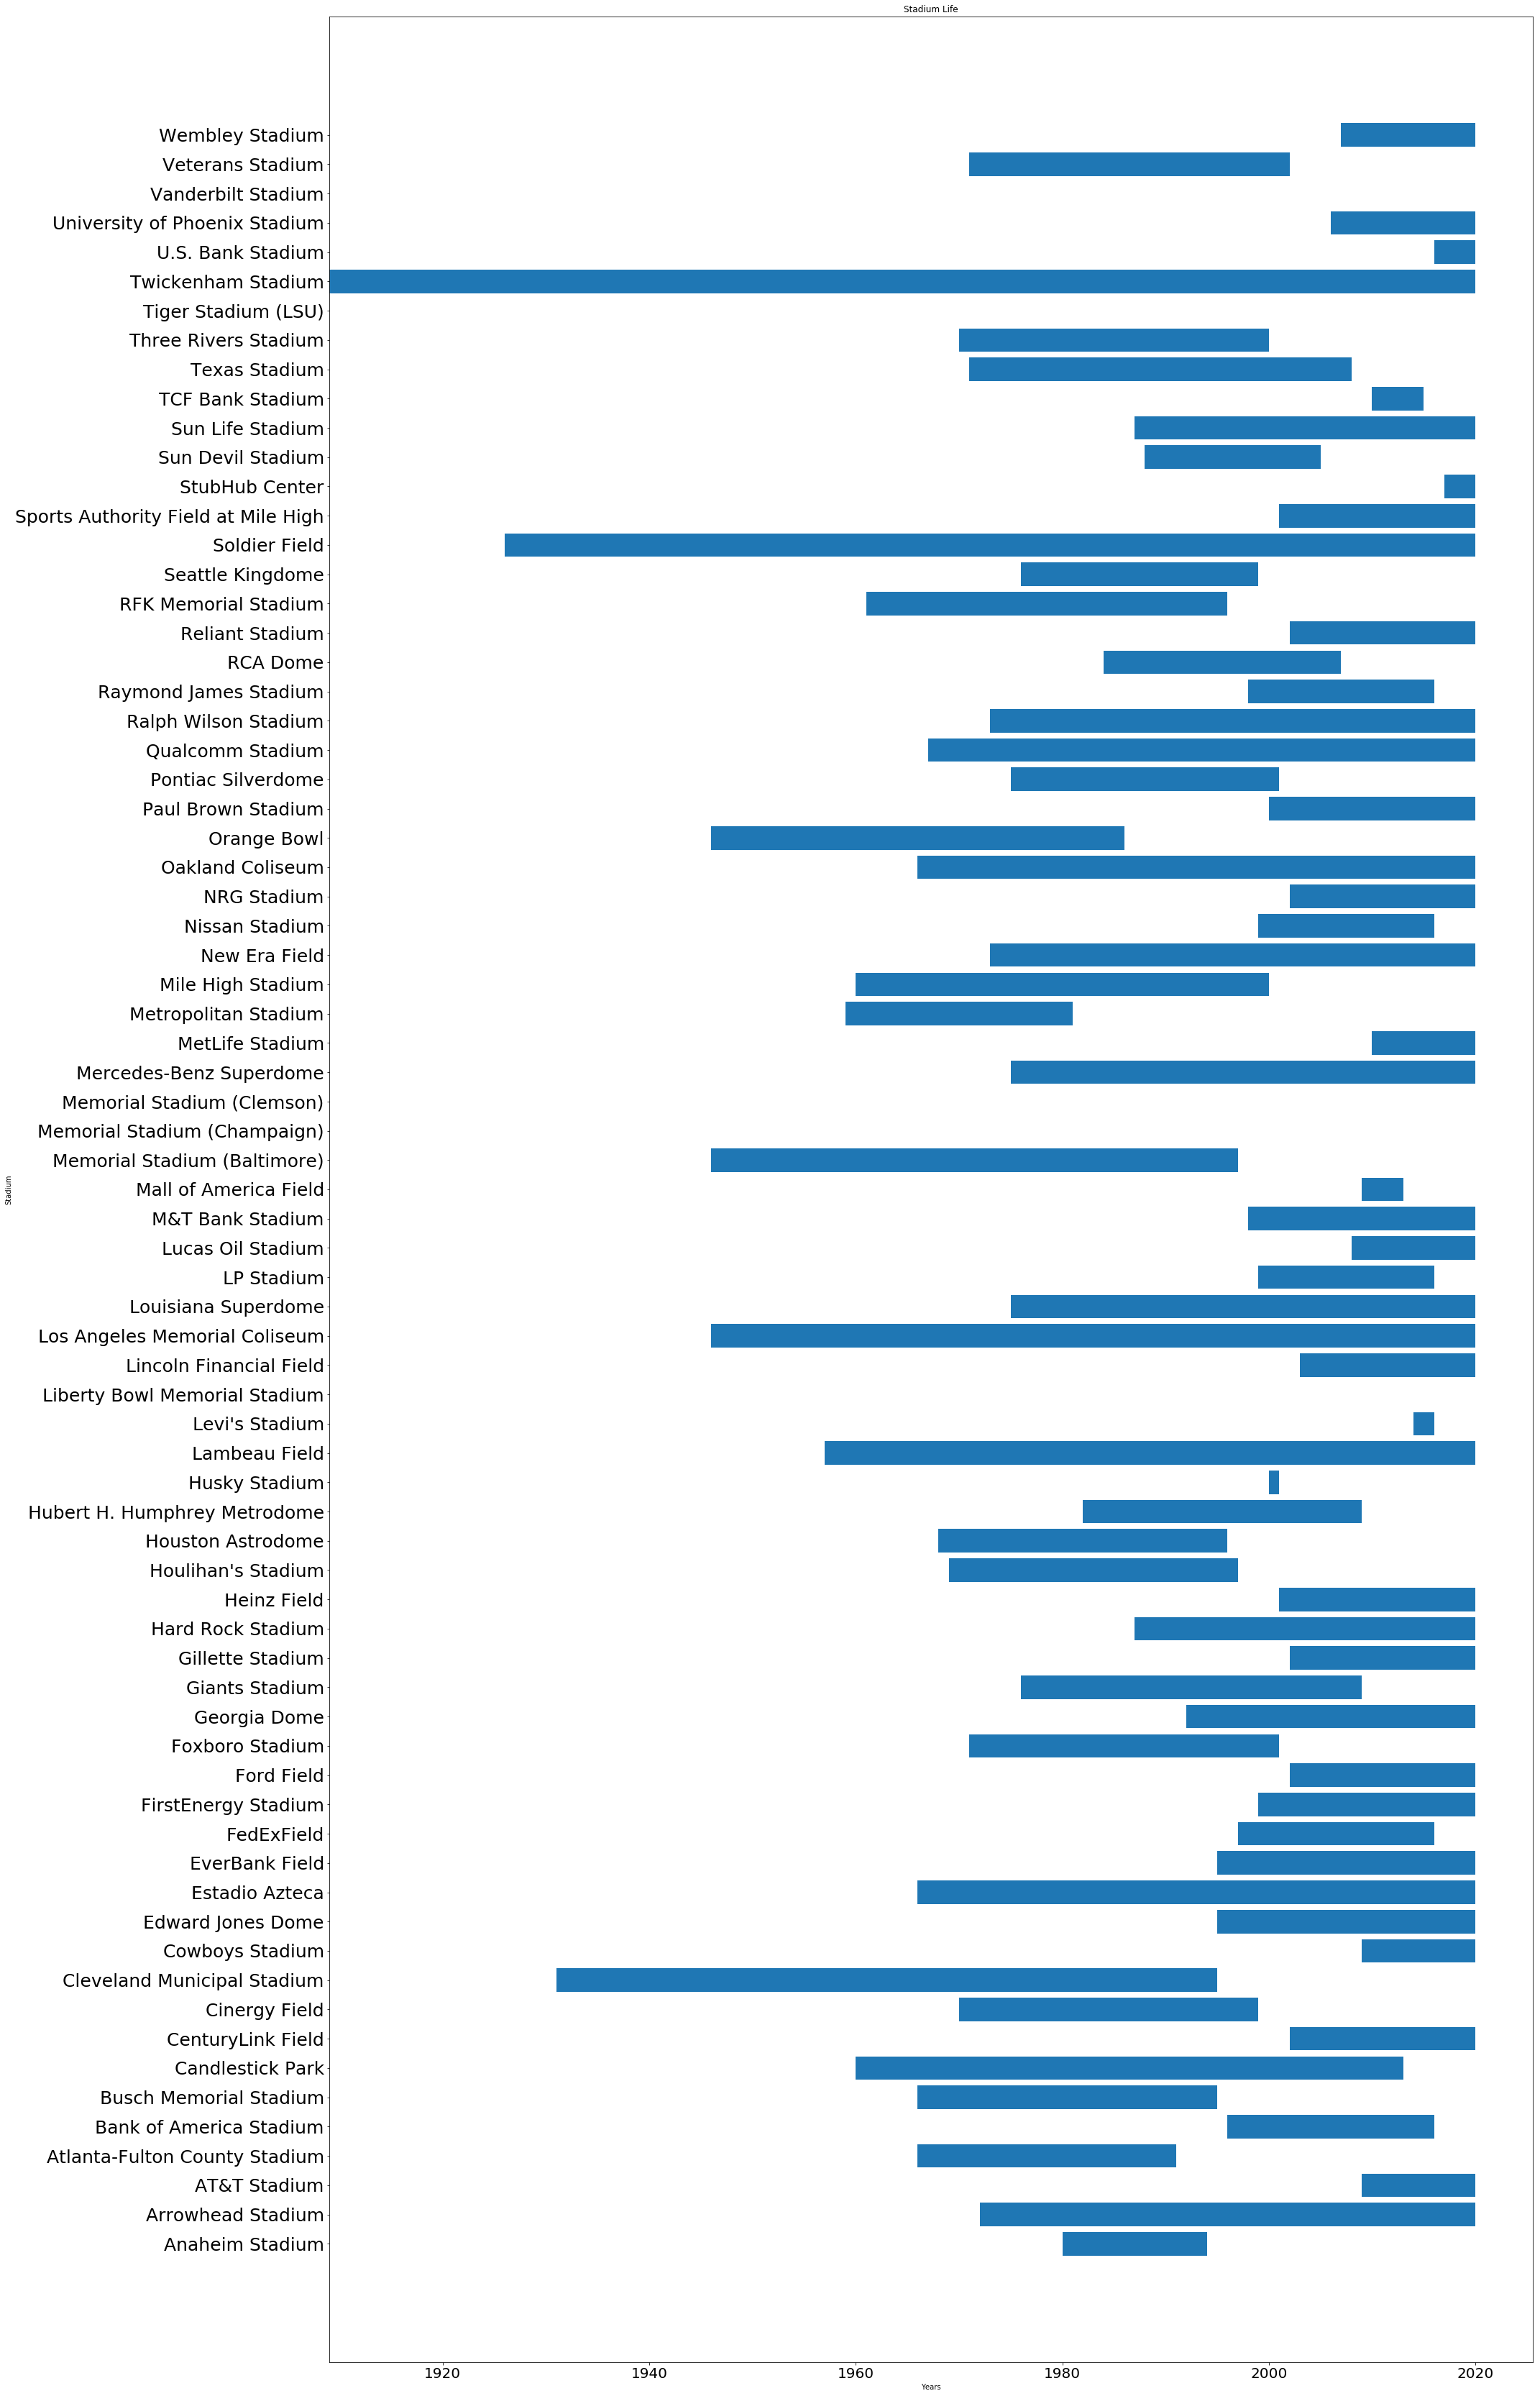

In [17]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 60
plt.rcParams["figure.figsize"] = fig_size
begin = nfl_stadiums.stadium_open.values
end =   nfl_stadiums.stadium_close.values
event = nfl_stadiums.stadium_name.values

plt.barh(range(len(begin)),  end-begin, left=begin)
plt.xticks(fontsize=20)
plt.yticks(range(73), event, fontsize=25)
plt.title("Stadium Life")
plt.xlabel("Years")
plt.ylabel("Stadium")
plt.show()

In [36]:
print ('Stadium Type', "Counts")
nfl_stadiums.stadium_weather_type.value_counts()

Stadium Type Counts


cold        23
moderate    18
dome        18
warm        14
Name: stadium_weather_type, dtype: int64

### 